#Introduction

#In the realm of time series analysis, accurate forecasting is crucial for informed decision-making across various domains, including finance, economics, and resource management. This project focuses on evaluating and comparing two prominent time series forecasting models: ARIMA (Autoregressive Integrated Moving Average) and SARIMA (Seasonal Autoregressive Integrated Moving Average). By leveraging these models, we aim to predict future values of a specific time series dataset, which encapsulates the percentage contribution of a variable over time. The effectiveness of these models will be assessed through various error metrics, such as Mean Absolute Error (MAE) and Root Mean Square Error (RMSE), alongside visual representations of the forecasts.


#Dataset Description

#The dataset titled "9-quarterly-contribu-kp-contrib.csv" contains 1,288 observations representing the percentage contribution of various economic sectors over a span of time from 2011 to 2024. Each record is organized by year and quarter, providing a quarterly breakdown of contributions from sectors such as agriculture, mining, manufacturing, and services, among others. The dataset includes columns for both English and Arabic descriptions of the sectors, ensuring accessibility for different language speakers.

#Key features of the dataset include:

#Year: The year of the observation.
#Quarter: The specific quarter of the year (Q1, Q2, Q3, Q4).
#Sector: The type of economic sector, specified in both English and Arabic.
#Contribution %: The percentage contribution of each sector to the overall economy at constant prices.
#This dataset serves as a valuable resource for analyzing economic trends and understanding the dynamics of various sectors over time, enabling insights into how different areas contribute to overall economic performance.

Dataset Link: https://www.data.gov.bh/explore/dataset/9-quarterly-contribu-kp-contrib/information/?disjunctive.quarter&sort=-n


In [161]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import warnings
from scipy.stats import zscore
warnings.filterwarnings("ignore")

In [162]:
# Load the dataset
df = pd.read_csv('/content/9-quarterly-contribu-kp-contrib.csv')

In [163]:
# Display the first few rows
print(df.head())

     N  Year Quarter         الربع          sector (Constant Prices)  \
0  1.0  2011      Q1   الربع الأول  Agriculture,forestry and fishing   
1  2.0  2011      Q2  الربع الثاني  Agriculture,forestry and fishing   
2  3.0  2011      Q3  الربع الثالث  Agriculture,forestry and fishing   
3  4.0  2011      Q4  الربع الرابع  Agriculture,forestry and fishing   
4  5.0  2011      Q1   الربع الأول              Mining and quarrying   

        القطاع (الأسعار الثابتة)  contribution %  
0  الزراعة والحراجة وصيد الأسماك        0.285815  
1  الزراعة والحراجة وصيد الأسماك        0.273737  
2  الزراعة والحراجة وصيد الأسماك        0.280452  
3  الزراعة والحراجة وصيد الأسماك        0.298151  
4       التعدين واستغلال المحاجر       20.473089  


In [164]:
# Check the data types
print(df.dtypes)

N                           float64
Year                          int64
Quarter                      object
الربع                        object
sector (Constant Prices)     object
القطاع (الأسعار الثابتة)     object
contribution %              float64
dtype: object


In [165]:
# Display original columns
print("Original columns:", df.columns.tolist())

Original columns: ['N', 'Year', 'Quarter', 'الربع', 'sector (Constant Prices)', 'القطاع (الأسعار الثابتة)', 'contribution %']


In [166]:
# Unique values in the sector column
unique_sectors = df['sector (Constant Prices)'].unique()
print(unique_sectors)

['Agriculture,forestry and fishing' 'Mining and quarrying' 'Manufacturing'
 'Electricity, gas, steam and air conditioning supply'
 'Water supply; sewerage, waste management and remediation activities'
 'Construction'
 'Wholesale and retail trade; repair of motor vehicles and motorcycles'
 'Transportation and storage' 'Accommodation and food service activities'
 'Information and communication' 'Financial and insurance activities'
 'Realestate activities'
 'Professional, scientific and technical activities'
 'Administrative and support service activities'
 'Public administration and defence; compulsory social security'
 'Education' 'Human health and social work activities'
 'Arts, entertainment and recreation' 'Other service activities'
 'Activities of households as employers; undifferentiated goods -and of households for own use'
 'Total Value added at basic prices' 'Net Taxes on Products'
 'Gross Domestic Product']


In [167]:
duplicates = df['sector (Constant Prices)'].duplicated().sum()
print(f'Duplicates: {duplicates}')

Duplicates: 1265


In [168]:
print(df.isnull().sum())

N                           0
Year                        0
Quarter                     0
الربع                       0
sector (Constant Prices)    0
القطاع (الأسعار الثابتة)    0
contribution %              0
dtype: int64


In [169]:
# Drop Arabic columns — adjust these names if needed
df = df.drop(columns=['القطاع (الأسعار الثابتة)', 'الربع','N'])

In [170]:
# Display original columns
print("Original columns:", df.columns.tolist())

Original columns: ['Year', 'Quarter', 'sector (Constant Prices)', 'contribution %']


In [171]:
# Convert the 'Year' and 'Quarter' into a datetime index
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Quarter'].str.replace('Q', '') + '-01')
df.set_index('Date', inplace=True)

# Select the relevant sector for forecasting (e.g., "Manufacturing")
sector_data = df[df['sector (Constant Prices)'] == 'Manufacturing']['contribution %']

In [172]:
df.head()

,Year,Quarter,sector (Constant Prices),contribution %
Date,,,,
2011-01-01,2011,Q1,"Agriculture,forestry and fishing",0.285815
2011-02-01,2011,Q2,"Agriculture,forestry and fishing",0.273737
2011-03-01,2011,Q3,"Agriculture,forestry and fishing",0.280452
2011-04-01,2011,Q4,"Agriculture,forestry and fishing",0.298151
2011-01-01,2011,Q1,Mining and quarrying,20.473089


In [173]:
# Summary statistics
print("\n📊 Descriptive Statistics:")
print(df['contribution %'].describe())


📊 Descriptive Statistics:
count    1288.000000
mean       12.949950
std        27.011765
min         0.077394
25%         1.243771
50%         3.433675
75%         7.887469
max       100.000000
Name: contribution %, dtype: float64


#The dataset has a wide range of contribution percentages, with an average of approximately 12.95% but a high standard deviation of 27.01, indicating significant variability.The minimum value is quite low (0.08%), while the maximum is 100%, suggesting that some sectors contribute very little while others contribute fully.The median (3.43%) is much lower than the mean, indicating a right-skewed distribution where a few sectors have very high contributions, pulling the mean upwards.Overall, these statistics suggest that there is considerable variation in sector contributions, with many sectors contributing relatively little, while a few contribute significantly more. This could be important for identifying outliers or sectors that may require further investigation.

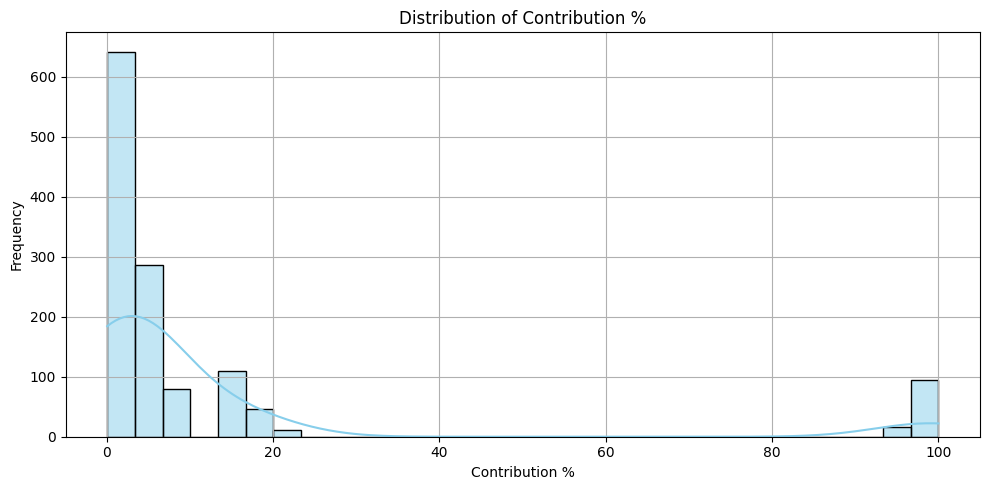

In [174]:
# Plot: Histogram with KDE
plt.figure(figsize=(10, 5))
sns.histplot(df['contribution %'], kde=True, bins=30, color='skyblue')
plt.title("Distribution of Contribution %")
plt.xlabel("Contribution %")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

#In the above histogram, X-axis represents the contribution percentages, ranging from zero to hundred. Each bar corresponds to a range of contribution percentages. Y-axis shows the frequency of datapoints within each contribution percentage range. It shows how many data points fall into each bin. The bars represent the frequency of contributions within specific intervals. The KDE (Kernel Density Estimate) provides a smoothed curve of the distribution.

#Right-Skewed Distribution:The histogram shows a clear right skew, meaning that a majority of the contribution percentages are clustered towards the lower end (near 0%).The distribution has a long tail extending towards the higher percentages, indicating that while many sectors contribute very little, a few sectors contribute significantly more.

#Concentration of Low Values:A large number of sectors have contributions close to 0%, as seen by the tall bars on the left side of the histogram. This suggests that many sectors contribute minimally to the overall percentage.

#Few High Values:As the contribution percentage increases, the frequency of occurrences decreases sharply. The bars representing higher contribution percentages (e.g., above 20%) are much shorter, indicating that very few sectors fall into these categories.

#KDE Curve: The KDE line shows that the density of contributions decreases as the percentage increases. It peaks around the lower values and tapers off towards the higher end, reinforcing the idea of a right-skewed distribution.

#Overall:The plot highlights a significant concentration of low contribution percentages among the sectors, with very few sectors contributing at higher levels.This distribution is indicative of potential outliers or sectors that may require further investigation. Understanding this distribution can help in decision-making processes, such as identifying sectors that could be targeted for growth or improvement. the histogram suggests that while most sectors have low contributions, a handful of sectors might be driving the overall contributions significantly.

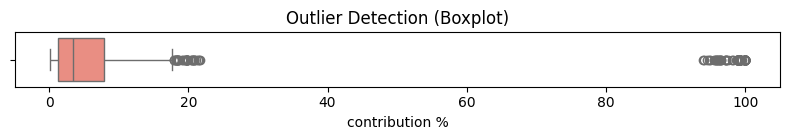

In [175]:
# Plot: Boxplot for Outliers
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df['contribution %'], color='salmon')
plt.title("Outlier Detection (Boxplot)")
plt.tight_layout()
plt.show()

#Central Tendency:The median contribution percentage is indicated by the line inside the box. This gives a good indication of the central tendency of the data.

#Spread of Data:The length of the box (IQR) shows the spread of the middle 50% of the data. A wider box indicates greater variability, while a narrower box suggests that the contributions are more similar.

#Presence of Outliers:The individual points outside the whiskers represent outliers, which in this case are higher contribution percentages. These outliers indicate that there are some sectors that contribute significantly more than the majority.
#The presence of these outliers suggests that while most sectors have low contributions, a few stand out as having much higher contributions.

#Data Distribution:The boxplot reinforces the earlier histogram observation that the distribution of contribution percentages is right-skewed, with many low values and a few very high values.

#Summary
#The boxplot provides a clear visual representation of the central tendency, spread, and presence of outliers in the contribution % data.
#The identified outliers signify sectors that contribute disproportionately compared to others, which could warrant further investigation or consideration in decision-making.
#Overall, this visualization is useful for quickly assessing the data's characteristics and identifying sectors that may behave differently than the majority.

In [176]:
# Apply log1p transformation to preserve all values (even zeros)
df['log_contribution'] = np.log1p(df['contribution %'])


#Transforming the contribution values using the log1p function, which helps keep all data points, including zeros, while making the data easier to analyze by reducing the impact of very high values. This is useful for better understanding and modeling the data without losing any information.

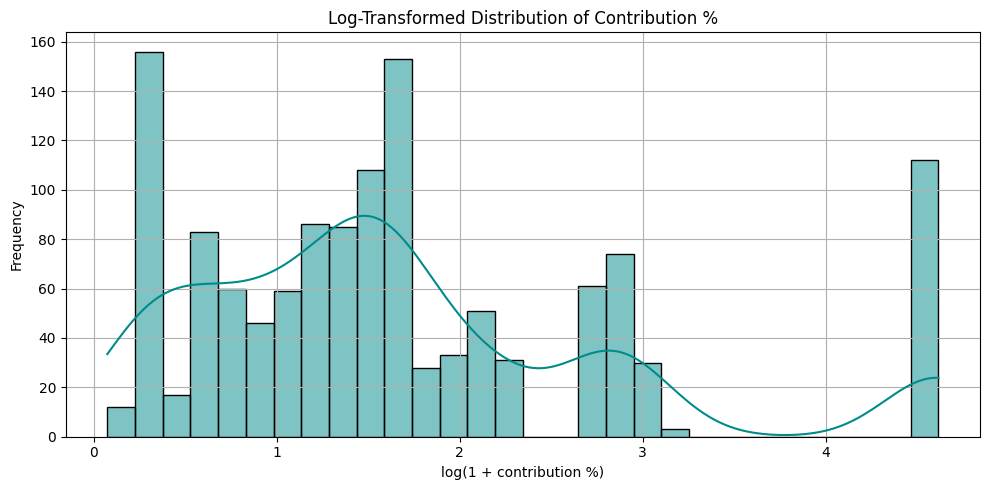

In [177]:
# Plot transformed histogram
plt.figure(figsize=(10, 5))
sns.histplot(df['log_contribution'], kde=True, color='darkcyan', bins=30)
plt.title("Log-Transformed Distribution of Contribution %")
plt.xlabel("log(1 + contribution %)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

#Distribution Shape:The histogram shows a more balanced distribution compared to the original data, with a more even spread of values across the log scale. This suggests that the log transformation has helped normalize the data.

#Concentration of Values:There are noticeable peaks in the histogram at specific log-transformed values (around 0, 1, and 3), indicating that many sectors have contributions that correspond to these transformed values.

#Reduction of Skewness:The log transformation has reduced the right skew seen in the original data. Instead of a long tail towards higher contributions, the log-transformed data appears more symmetric around the lower values.

#Outlier Influence:The transformation helps mitigate the influence of outliers by compressing their scale, making it easier to analyze the overall distribution without being affected by extreme values.

#Summary
#The log transformation has improved the distribution of the contribution % data, making it more symmetrical and easier to interpret.
#This visualization helps identify where the bulk of contributions lie and provides a clearer picture for further analysis or modeling.
#Overall, the transformed data is more suitable for statistical analysis, as it adheres more closely to the assumptions of normality often required by many statistical methods.

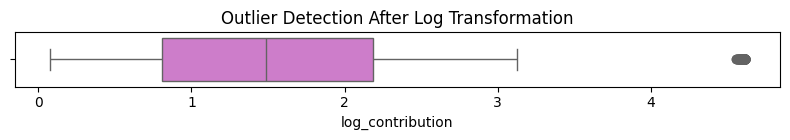

In [178]:
# Plot transformed boxplot
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df['log_contribution'], color='orchid')
plt.title("Outlier Detection After Log Transformation")
plt.tight_layout()
plt.show()

#Central Tendency:The median line inside the box indicates the central value of the log-transformed contributions. This provides insight into the typical contribution percentage after transformation.

#Spread of Data:The box's length (IQR) shows the spread of the middle 50% of the log-transformed data. A wider box indicates a greater range of contributions, while a narrower box suggests that the contributions are more similar.

#Outlier Detection:The presence of outliers is indicated by individual points outside the whiskers. These outliers indicate sectors that have significantly higher log-transformed contributions compared to the majority.

#Comparison to Original Data:The log transformation has likely reduced the influence of extreme values, making the overall distribution of contributions more balanced and less skewed.

#Summary
#The boxplot provides a clear visual representation of the central tendency, spread, and presence of outliers in the log-transformed contribution % data.
#The outliers highlight sectors with disproportionately high contributions, which may require further investigation.
#Overall, this visualization helps assess the data's characteristics after transformation, making it more suitable for analysis and interpretation.


In [179]:
# Print statistical summary
print(df['log_contribution'].describe())

count    1288.000000
mean        1.689882
std         1.183968
min         0.074545
25%         0.808158
50%         1.489228
75%         2.184642
max         4.615121
Name: log_contribution, dtype: float64


#The dataset has a wide range of log-transformed contribution values, with an average of approximately 1.69 and a standard deviation of 1.18, indicating significant variability.

#The median (1.49) is lower than the mean (1.69), suggesting a right-skewed distribution where a few sectors have very high contributions that pull the average up.

#The presence of low (0.07) and high (4.62) values indicates that while many sectors contribute minimally, there are a few that contribute significantly higher.

#Overall, these statistics provide useful insights into the distribution and variability of log-transformed contributions, helping to identify sectors that may need further analysis or attention

In [180]:
# Detect outliers using Z-score


df['z_score'] = zscore(df['contribution %'])
outliers = df[abs(df['z_score']) > 3]

print(f"\n🚨 Detected {len(outliers)} outliers using Z-score > 3:")
print(outliers[['Year', 'sector (Constant Prices)', 'contribution %', 'z_score']])


🚨 Detected 111 outliers using Z-score > 3:
            Year           sector (Constant Prices)  contribution %   z_score
Date                                                                         
2011-01-01  2011  Total Value added at basic prices       98.863725  3.181841
2011-02-01  2011  Total Value added at basic prices       98.906483  3.183425
2011-03-01  2011  Total Value added at basic prices       99.060622  3.189133
2011-04-01  2011  Total Value added at basic prices       99.291753  3.197693
2011-01-01  2011             Gross Domestic Product      100.000000  3.223923
...          ...                                ...             ...       ...
2024-04-01  2024  Total Value added at basic prices       94.106399  3.005652
2024-01-01  2024             Gross Domestic Product      100.000000  3.223923
2024-02-01  2024             Gross Domestic Product      100.000000  3.223923
2024-03-01  2024             Gross Domestic Product      100.000000  3.223923
2024-04-01  2024    


#Z-score Calculation:

#The Z-score measures how many standard deviations a data point is from the mean. A Z-score greater than 3 (or less than -3) is typically considered an outlier, indicating that the value is significantly different from the mean of the dataset.

#Outlier Detection:

#The code detects outliers in the contribution % column by calculating the Z-score for each observation and identifying those with an absolute Z-score greater than 3.

#Number of Outliers:

#Detected Outliers: The output indicates that 111 outliers were detected based on the Z-score criterion (Z > 3). This means there are 111 values that are significantly higher than the average contribution percentage.

#Outlier Details:

#The displayed DataFrame includes several columns:
#Year: The year associated with the data point.
#Sector (Constant Prices): The specific economic sector being analyzed.
#Contribution %: The actual contribution percentage for each outlier.
#Z-score: The Z-score value indicating how far each outlier is from the mean.

#Example Entries:

#The first few rows show sectors with contribution percentages around 98% to 100%, with corresponding Z-scores around 3.18 to 3.22. These high values suggest that these sectors are contributing significantly more than the average, which might indicate special circumstances or events affecting their contributions.

#Summary Interpretation
#The detection of 111 outliers indicates that there are several sectors with contribution percentages that are exceptionally high compared to the overall dataset.

#Identifying these outliers is crucial for further analysis, as they may represent important economic phenomena, such as exceptional growth, anomalies, or data errors.

#Investigating these outliers can help in understanding the underlying factors driving such high contributions, which could have implications for economic policy, sector analysis, or business strategy.

#Overall, this Z-score method provides a systematic way to identify and analyze outliers, enhancing the reliability of subsequent analyses

In [181]:
# Unique values in the sector column
unique_sectors = df['sector (Constant Prices)'].unique()
print(unique_sectors)

['Agriculture,forestry and fishing' 'Mining and quarrying' 'Manufacturing'
 'Electricity, gas, steam and air conditioning supply'
 'Water supply; sewerage, waste management and remediation activities'
 'Construction'
 'Wholesale and retail trade; repair of motor vehicles and motorcycles'
 'Transportation and storage' 'Accommodation and food service activities'
 'Information and communication' 'Financial and insurance activities'
 'Realestate activities'
 'Professional, scientific and technical activities'
 'Administrative and support service activities'
 'Public administration and defence; compulsory social security'
 'Education' 'Human health and social work activities'
 'Arts, entertainment and recreation' 'Other service activities'
 'Activities of households as employers; undifferentiated goods -and of households for own use'
 'Total Value added at basic prices' 'Net Taxes on Products'
 'Gross Domestic Product']


In [182]:
# Exclude rows where 'sector (Constant Prices)' is 'Gross Domestic Product' or 'Total Value added at basic prices'
df = df[~df['sector (Constant Prices)'].isin(['Gross Domestic Product', 'Total Value added at basic prices'])].copy()

In [183]:
# Calculate the average contribution percentage for each sector and sort the results in descending order
sector_avg = df.groupby('sector (Constant Prices)')['contribution %'].mean().sort_values(ascending=False)


In [184]:
# Top 10 most contributing sectors
top_10 = sector_avg.head(10)

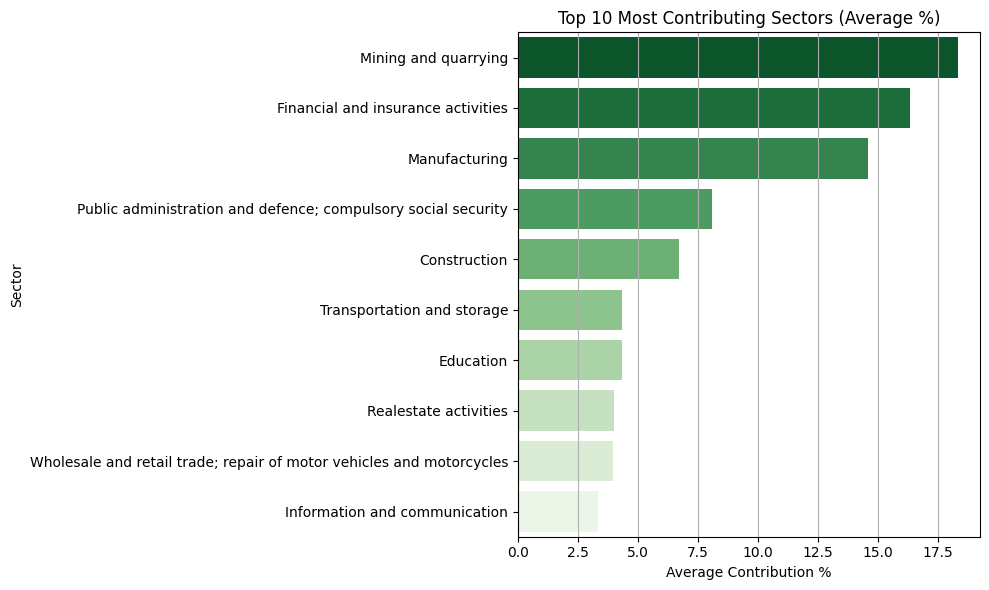

In [185]:
# Plot Top 10
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10.values, y=top_10.index, palette='Greens_r')
plt.title("Top 10 Most Contributing Sectors (Average %)")
plt.xlabel("Average Contribution %")
plt.ylabel("Sector")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

#The chart effectively visualizes the average contributions of various sectors, highlighting the top contributors to the economy.
#This information is crucial for economic analysis, resource allocation, and strategic planning, as it identifies which sectors are driving economic performance.
#Overall, the chart serves as a valuable tool for stakeholders looking to understand sectoral dynamics and make informed decisions based on contribution levels.

In [186]:
# Bottom 10 least contributing sectors
bottom_10 = sector_avg.tail(10)

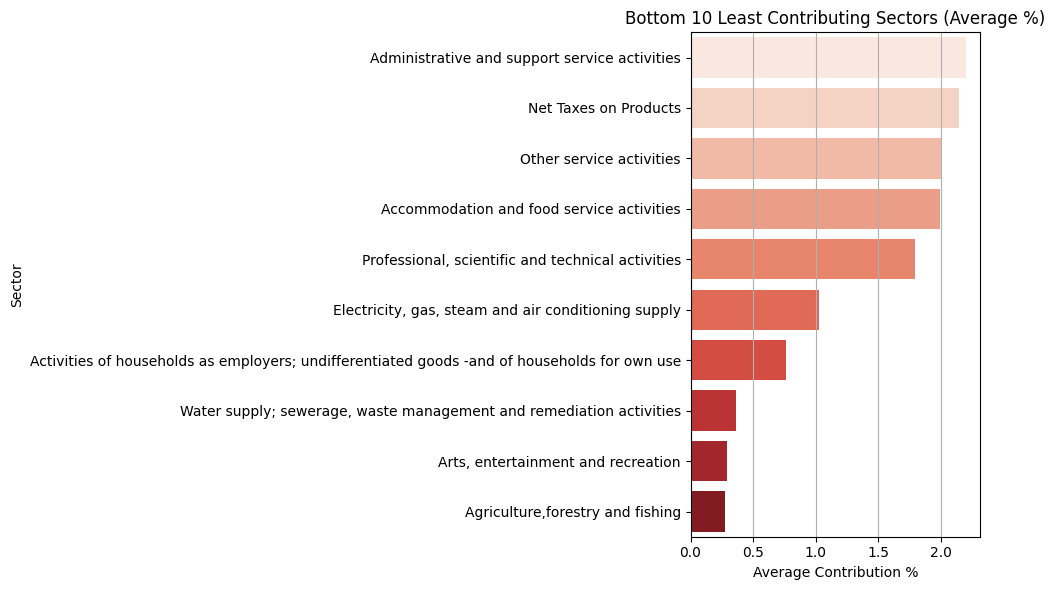

In [187]:
# Plot Bottom 10
plt.figure(figsize=(10, 6))
sns.barplot(x=bottom_10.values, y=bottom_10.index, palette='Reds')
plt.title("Bottom 10 Least Contributing Sectors (Average %)")
plt.xlabel("Average Contribution %")
plt.ylabel("Sector")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

#The chart highlights the bottom 10 sectors in terms of average contributions, providing insight into sectors that may have limited economic influence.
#This information is valuable for stakeholders looking to identify areas for potential growth or improvement in the economy.
#Overall, the chart serves as a useful tool for understanding sectoral dynamics and guiding strategic decisions regarding resource allocation and policy development.

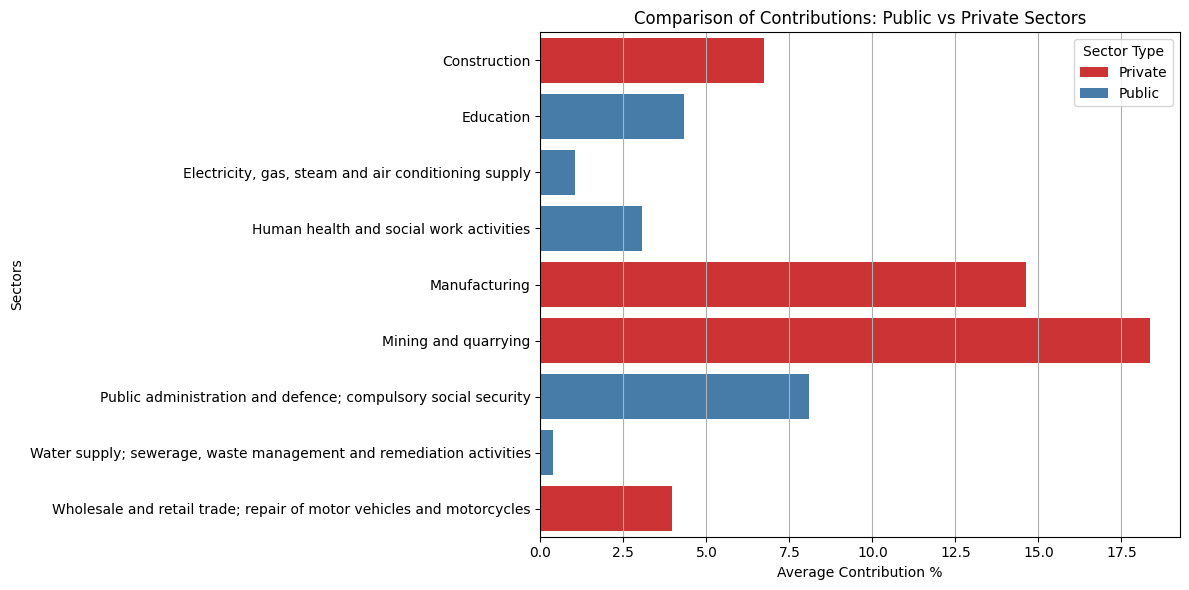

In [210]:
# Define public and private sectors
public_sectors = [
    'Public administration and defence; compulsory social security',
    'Education',
    'Human health and social work activities',
    'Electricity, gas, steam and air conditioning supply',
    'Water supply; sewerage, waste management and remediation activities'
]

private_sectors = [
    'Mining and quarrying',
    'Manufacturing',
    'Construction',
    'Wholesale and retail trade; repair of motor vehicles and motorcycles'
]

# Filter the dataset for selected sectors
selected_sectors = public_sectors + private_sectors
filtered_df = df[df['sector (Constant Prices)'].isin(selected_sectors)]

# Calculate average contributions for each sector
sector_avg = filtered_df.groupby('sector (Constant Prices)')['contribution %'].mean().reset_index()

# Create a color mapping for public and private sectors
sector_avg['Sector Type'] = sector_avg['sector (Constant Prices)'].apply(
    lambda x: 'Public' if x in public_sectors else 'Private'
)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=sector_avg, x='contribution %', y='sector (Constant Prices)', hue='Sector Type', palette='Set1')
plt.title("Comparison of Contributions: Public vs Private Sectors")
plt.xlabel("Average Contribution %")
plt.ylabel("Sectors")
plt.legend(title='Sector Type')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

#Public vs Private Sectors

#Overview
#The bar plot compares the average contributions of selected public and private sectors to the economy, highlighting differences in their economic impact.

#Key Observations
#Private Sector Dominance:

#Mining and Quarrying: This sector has the highest average contribution percentage, indicating its critical role in Bahrain's economy. Its performance is significantly stronger compared to the public sectors shown.

#Manufacturing: Also a key private sector, manufacturing shows a substantial contribution, suggesting robust industrial activity.

#Public Sector Contributions:

#Education: Among public sectors, education has a notable contribution, reflecting its importance in workforce development and long-term economic growth.

#Human Health and Social Work Activities: This sector has a moderate contribution, indicating its essential role in societal well-being, although it is still lower than the contributions from major private sectors.

#Utility Sectors:Electricity, Gas, Steam and Air Conditioning Supply: This essential utility sector shows a contribution similar to some private sectors, emphasizing its role in both public service and economic activities.
#Water Supply; Sewage, Waste Management and Remediation Activities: This sector contributes less than the major private sectors but is crucial for public health and environmental management.

#Construction Sector:The construction sector, classified as private, shows strong contributions, reflecting ongoing infrastructure development, which is vital for economic growth.

#Public Administration and Defence:This sector has a lower average contribution compared to the leading private sectors, which may indicate that while it is essential for governance and security, its economic impact is not as significant in terms of contribution percentage.

#Comparative Analysis
#Economic Impact: Private sectors, particularly mining and manufacturing, significantly outpace public sectors in terms of contribution. This suggests that the private sector is a major driver of Bahrain's economic performance.

#Investment Focus: The stark difference in contributions highlights the potential need for further investment and support in public sectors like education and health to enhance their economic impact.
#Policy Implications: Understanding these contributions can inform policymakers regarding where to allocate resources, promote growth, and encourage diversification of the economy.

#Conclusion
#The plot effectively illustrates the contrasting contributions of public and private sectors, emphasizing the dominance of the private sector in driving economic growth. It suggests that while public sectors are essential for societal functions, their economic contributions lag behind those of private industries, highlighting areas for potential development and investment.



In [188]:
train = sector_data[:-4]  # Use all except the last year
test = sector_data[-4:]    # Last year for testing

In [189]:


# Check stationarity with Augmented Dickey-Fuller test
#result = adfuller(train)
#print('ADF Statistic:', result[0])
#print('p-value:', result[1])

# Fit ARIMA model (p, d, q)
p, d, q = 1, 1, 1  # You can adjust these parameters after checking ACF and PACF plots
arima_model = ARIMA(train, order=(p, d, q))
arima_fit = arima_model.fit()
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         contribution %   No. Observations:                   52
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -33.380
Date:                Tue, 08 Jul 2025   AIC                             72.760
Time:                        19:24:09   BIC                             78.556
Sample:                             0   HQIC                            74.975
                                 - 52                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4068      0.140      2.916      0.004       0.133       0.680
ma.L1         -0.9463      0.086    -10.967      0.000      -1.115      -0.777
sigma2         0.2106      0.053      3.944      0.0

#Model Summary
#Dependent Variable:

#contribution %: This indicates the variable being modeled, which is the percentage contribution in this case.

#No. Observations:

#52: The model was fitted using 52 observations from the dataset.

#Model Specification:

#ARIMA(1, 1, 1): The model is an Autoregressive Integrated Moving Average model with:
#p=1: One lag of the autoregressive term.
#d=1: Differencing is applied once to stabilize the mean.
#q=1: One lag of the moving average term.

#Log Likelihood:

#-33.380: This value indicates how well the model fits the data. Higher (less negative) values suggest a better fit.

#Information Criteria:

#AIC (Akaike Information Criterion): 72.760
#BIC (Bayesian Information Criterion): 78.556
#HQIC (Hannan-Quinn Information Criterion): 74.975
#Lower values of AIC, BIC, and HQIC indicate a better model fit, with penalties for complexity (number of parameters).

#Coefficients
#AR Coefficient (ar.L1):

#coef: 0.4068: This indicates a positive relationship; past values of the series positively influence future values.
#P>|z|: 0.004: This p-value indicates statistical significance (p < 0.05), suggesting that the autoregressive term is significantly different from zero.

#MA Coefficient (ma.L1):

#coef: -0.9463: This indicates a negative relationship; past forecast errors negatively influence future values.
#P>|z|: 0.000: This p-value indicates strong statistical significance, suggesting that the moving average term is significantly different from zero.

#Variance (sigma2):

#coef: 0.2106: This represents the estimated variance of the errors in the model.
#P>|z|: 0.000: The significance of this value indicates that there is variability in the model errors that is statistically significant.
#Diagnostic Tests

#Ljung-Box (L1) Test:

#Q: 0.04, Prob(Q): 0.85: This tests for autocorrelation in the residuals. A high p-value (greater than 0.05) suggests that there is no significant autocorrelation, indicating that the model's residuals are likely white noise.

#Jarque-Bera (JB) Test:

#Prob(JB): 0.66: This tests for normality of the residuals. A high p-value suggests that the residuals are normally distributed.

#Heteroskedasticity Test:

#H: 1.40, Prob(H): 0.50: This tests for constant variance in the residuals. A high p-value suggests that there is no evidence of heteroskedasticity.

#Skew and Kurtosis:

#Skew: -0.08: Indicates a slight left skew in the residuals, which is close to zero.
#Kurtosis: 2.40: Indicates less peakedness than a normal distribution (which has a kurtosis of 3).

#Summary
#The SARIMAX model appears to fit the data reasonably well, with significant AR and MA coefficients, indicating that past values and past errors are important predictors.

#The model diagnostics suggest that the residuals are approximately white noise and normally distributed, which is a good sign for the validity of the model.
#The AIC and BIC values can be used for model comparison if you decide to try different configurations. Overall, this model provides a solid foundation for forecasting the percentage contribution.

In [190]:


# Fit SARIMA model (p, d, q, P, D, Q, s)
P, D, Q, s = 1, 1, 1, 4  # Seasonal order parameters
sarima_model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_fit = sarima_model.fit()
print(sarima_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                    contribution %   No. Observations:                   52
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood                 -31.760
Date:                           Tue, 08 Jul 2025   AIC                             73.519
Time:                                   19:24:10   BIC                             82.770
Sample:                                        0   HQIC                            77.000
                                            - 52                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4133      0.183      2.263      0.024       0.055       0.771
ma.L1         -0.9920      0.946     -1.048

#Model Summary
#Dependent Variable:

#contribution %: This is the variable being modeled, representing the percentage contribution.

#No. Observations:

#52: The model was fitted using 52 observations.

#Model Specification:

#SARIMAX(1, 1, 1)x(1, 1, 1, 4): This indicates a Seasonal Autoregressive Integrated Moving Average model with:
#(1, 1, 1):
#p=1: One lag of the autoregressive term (AR).
#d=1: Differencing applied once to stabilize the mean.
#q=1: One lag of the moving average term (MA).
#x(1, 1, 1, 4): Seasonal component:
#P=1: One lag of the seasonal autoregressive term.
#D=1: Seasonal differencing applied once.
#Q=1: One lag of the seasonal moving average term.
#s=4: Seasonal period (e.g., quarterly data).

#Log Likelihood:

#-31.760: This value indicates the goodness of fit; higher values (less negative) suggest a better model fit.

#Information Criteria:

#AIC (73.519), BIC (82.770), HQIC (77.000): These criteria are used for model selection, with lower values indicating a better fit while penalizing for the number of parameters.

#Coefficients
#AR Coefficient (ar.L1):

#coef: 0.4133: A positive relationship, suggesting that past values of the series positively influence future values.
#P>|z|: 0.024: Statistically significant (p < 0.05), indicating that this autoregressive term is important.

#MA Coefficient (ma.L1):

#coef: -0.9920: Indicates a negative relationship; past forecast errors negatively influence future values.
#P>|z|: 0.294: Not statistically significant, suggesting that this moving average term may not be a critical predictor.

#Seasonal AR Coefficient (ar.S.L4):

#coef: 0.5616: This positive coefficient indicates that past seasonal values have a positive influence.
#P>|z|: 0.054: This is marginally significant, suggesting it may be worth considering in the model.
#Seasonal MA Coefficient (ma.S.L4):

#coef: -0.9427: Indicates a negative influence from past seasonal forecast errors.
#P>|z|: 0.103: Not statistically significant, suggesting limited contribution.
#Variance (sigma2):

#coef: 0.1915: This represents the estimated variance of the errors in the model.
#P>|z|: 0.214: Not significant, indicating that the variability in the model errors may not be substantial.

#Diagnostic Tests

#Ljung-Box (L1) Test:

#Q: 0.01, Prob(Q): 0.90: Indicates no significant autocorrelation in the residuals, suggesting the model captures the data well.

#Jarque-Bera (JB) Test:

#Prob(JB): 0.74: Suggests that the residuals are normally distributed, as a high p-value indicates no significant deviation from normality.

#Heteroskedasticity Test:

#H: 1.56, Prob(H): 0.38: Indicates no significant evidence of heteroskedasticity, suggesting constant variance in the residuals.

#Skew and Kurtosis:

#Skew: 0.03: Indicates a slight right skew, close to zero.
#Kurtosis: 2.45: Indicates a distribution that is less peaked than normal (kurtosis of 3).

#Summary
#The SARIMAX model fits the data reasonably well, with a significant AR term and a seasonal AR term that is marginally significant.
#The moving average terms, both seasonal and non-seasonal, do not show strong significance, suggesting they may not be critical for the model.
#Diagnostic tests indicate that the residuals are white noise and normally distributed, which supports the validity of the model.
#The AIC and BIC values can be used for comparing this model with others. Overall, this model provides a solid basis for forecasting the percentage contribution, but further refinement may be necessary depending on the context and additional data.


In [191]:
# Forecasting with ARIMA
arima_forecast = arima_fit.forecast(steps=len(test))

# Forecasting with SARIMA
sarima_forecast = sarima_fit.forecast(steps=len(test))

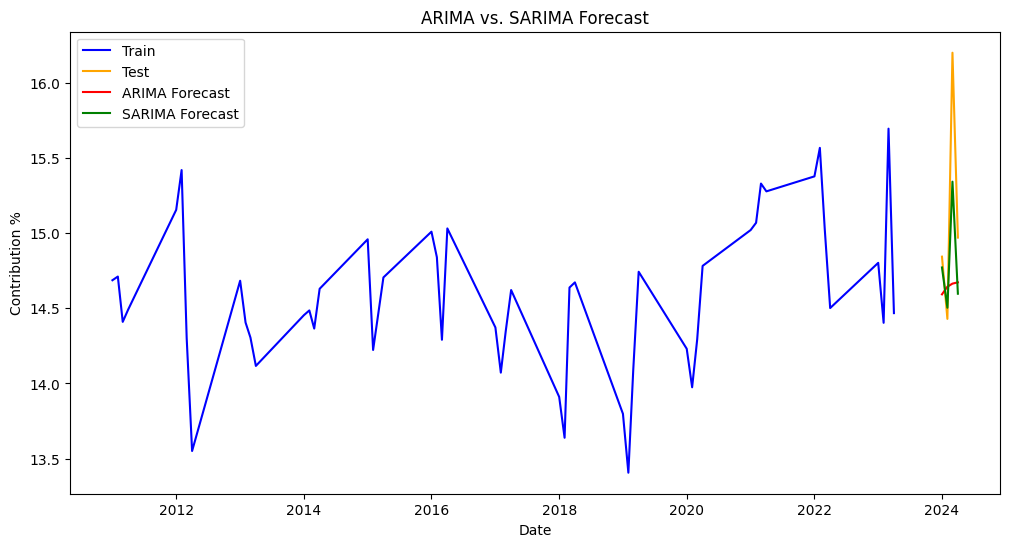

ARIMA MAE: 0.574096675125463, RMSE: 0.6379706027984282
SARIMA MAE: 0.34394855203784847, RMSE: 0.22100807069150188


In [192]:

# Calculate errors
arima_mae = mean_absolute_error(test, arima_forecast)
sarima_mae = mean_absolute_error(test, sarima_forecast)

arima_rmse = mean_squared_error(test, arima_forecast)
sarima_rmse = mean_squared_error(test, sarima_forecast)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='red')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='green')
plt.title('ARIMA vs. SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Contribution %')
plt.legend()
plt.show()

# Print errors
print(f'ARIMA MAE: {arima_mae}, RMSE: {arima_rmse}')
print(f'SARIMA MAE: {sarima_mae}, RMSE: {sarima_rmse}')

#Interpretation and Comparison of ARIMA and SARIMA Models
#Error Metrics:
#MAE (Mean Absolute Error):

#ARIMA MAE: 0.574: This indicates that, on average, the absolute difference between the predicted values and the actual values is approximately 0.574.
#SARIMA MAE: 0.344: This indicates a lower average absolute error compared to ARIMA, suggesting that the SARIMA model provides better predictions on average.

#RMSE (Root Mean Square Error):

#ARIMA RMSE: 0.638: This measures the square root of the average squared differences between predicted and actual values. A higher RMSE indicates larger prediction errors.

#SARIMA RMSE: 0.221: The significantly lower RMSE for SARIMA suggests that it not only has smaller average errors but also fewer large errors compared to ARIMA.

#Visual Comparison
#Forecast Plot:
#The plot shows three lines:
#Train (Blue): Represents the historical training data.
#Test (Orange): Represents the actual values from the test set.
#ARIMA Forecast (Green): Displays the predictions made by the ARIMA model.
#SARIMA Forecast (Red): Displays the predictions made by the SARIMA model.
#Key Observations from the Plot:
#Fit to Training Data:

#Both models seem to capture the general trend of the training data well, but the SARIMA model appears to follow the trend more closely.

#Test Data Predictions:

#The SARIMA forecast seems to be more aligned with the actual test data (orange line), indicating better predictive performance.
#The ARIMA forecast shows more deviation from the actual values, particularly towards the end of the test period, which correlates with its higher error metrics.

#Summary of Findings
#SARIMA Outperforms ARIMA:

#The SARIMA model consistently shows lower MAE and RMSE compared to the ARIMA model, indicating superior predictive accuracy.
#This suggests that incorporating seasonal components (as SARIMA does) improves forecasting performance for this particular dataset.

#Importance of Seasonality:

#The results highlight the importance of capturing seasonal patterns in time series data. The SARIMA model's ability to include seasonal effects likely contributes to its better performance.

#Practical Implications:

#If the goal is to forecast future values accurately in a context where seasonality is present, the SARIMA model would be the preferred choice based on these results.

#Overall, the SARIMA model appears to provide a more robust and reliable forecasting capability for the given time series data.

In [193]:
# Unique values in the sector column
unique_sectors = df['sector (Constant Prices)'].unique()
print(unique_sectors)

['Agriculture,forestry and fishing' 'Mining and quarrying' 'Manufacturing'
 'Electricity, gas, steam and air conditioning supply'
 'Water supply; sewerage, waste management and remediation activities'
 'Construction'
 'Wholesale and retail trade; repair of motor vehicles and motorcycles'
 'Transportation and storage' 'Accommodation and food service activities'
 'Information and communication' 'Financial and insurance activities'
 'Realestate activities'
 'Professional, scientific and technical activities'
 'Administrative and support service activities'
 'Public administration and defence; compulsory social security'
 'Education' 'Human health and social work activities'
 'Arts, entertainment and recreation' 'Other service activities'
 'Activities of households as employers; undifferentiated goods -and of households for own use'
 'Net Taxes on Products']


In [194]:
# Select the relevant sector for forecasting (e.g., "Manufacturing")
sector_data = df[df['sector (Constant Prices)'] == 'Accommodation and food service activities']['contribution %']

In [195]:
train = sector_data[:-4]  # Use all except the last year
test = sector_data[-4:]    # Last year for testing

In [196]:
# Fit ARIMA model (p, d, q)
p, d, q = 1, 1, 1  # You can adjust these parameters after checking ACF and PACF plots
arima_model = ARIMA(train, order=(p, d, q))
arima_fit = arima_model.fit()
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         contribution %   No. Observations:                   52
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  10.978
Date:                Tue, 08 Jul 2025   AIC                            -15.956
Time:                        19:24:10   BIC                            -10.161
Sample:                             0   HQIC                           -13.742
                                 - 52                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5039      0.382      1.318      0.188      -0.245       1.253
ma.L1         -0.7070      0.356     -1.987      0.047      -1.404      -0.010
sigma2         0.0380      0.004      8.622      0.0

#Summary of SARIMAX Results
#Dependent Variable: Contribution %
#Observations: 52
#Model: ARIMA(1, 1, 1)
#Key Metrics:
#Log Likelihood: 10.978
#AIC: -15.956 (lower is better)
#BIC: -10.161
#HQIC: -13.742
#Coefficients:
#AR Coefficient (ar.L1): 0.5039 (not significant, p = 0.188)
#MA Coefficient (ma.L1): -0.7070 (significant, p = 0.047)
#Variance (sigma2): 0.0380 (significant, p < 0.001)
#Diagnostic Tests:
#Ljung-Box Test: No significant autocorrelation (p = 0.92)
#Jarque-Bera Test: Residuals not normally distributed (p < 0.001)
#Heteroskedasticity Test: Significant heteroskedasticity (p < 0.001)
#Conclusion
#The model shows a significant moving average component but lacks significance in the autoregressive part. Diagnostic tests indicate issues with normality and heteroskedasticity in the residuals, suggesting potential model improvements

In [197]:
# Fit SARIMA model (p, d, q, P, D, Q, s)
P, D, Q, s = 1, 1, 1, 4  # Seasonal order parameters
sarima_model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_fit = sarima_model.fit()
print(sarima_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                    contribution %   No. Observations:                   52
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood                   7.661
Date:                           Tue, 08 Jul 2025   AIC                             -5.322
Time:                                   19:24:11   BIC                              3.929
Sample:                                        0   HQIC                            -1.841
                                            - 52                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2901      0.918      0.316      0.752      -1.508       2.089
ma.L1         -0.4409      0.858     -0.514

#Summary of SARIMAX Results
#Dependent Variable: Contribution %
#Observations: 52
#Model: SARIMAX(1, 1, 1)x(1, 1, 1, 4)
#Key Metrics:
#Log Likelihood: 7.661
#AIC: -5.322 (lower is better)
#BIC: 3.929
#HQIC: -1.841
#Coefficients:
#AR Coefficient (ar.L1): 0.2901 (not significant, p = 0.752)
#MA Coefficient (ma.L1): -0.4409 (not significant, p = 0.607)
#Seasonal AR Coefficient (ar.S.L4): -0.0692 (not significant, p = 0.908)
#Seasonal MA Coefficient (ma.S.L4): -0.8073 (significant, p = 0.041)
#Variance (sigma2): 0.0382 (significant, p < 0.001)
#Diagnostic Tests:
#Ljung-Box Test: No significant autocorrelation (p = 0.93)
#Jarque-Bera Test: Residuals not normally distributed (p < 0.001)
#Heteroskedasticity Test: Significant heteroskedasticity (p < 0.001)
#Conclusion
#The model shows a significant seasonal moving average component but lacks significance in other terms. Diagnostic tests indicate issues with normality and heteroskedasticity in the residuals, suggesting potential areas for model improvement.

In [198]:
# Forecasting with ARIMA
arima_forecast = arima_fit.forecast(steps=len(test))

# Forecasting with SARIMA
sarima_forecast = sarima_fit.forecast(steps=len(test))

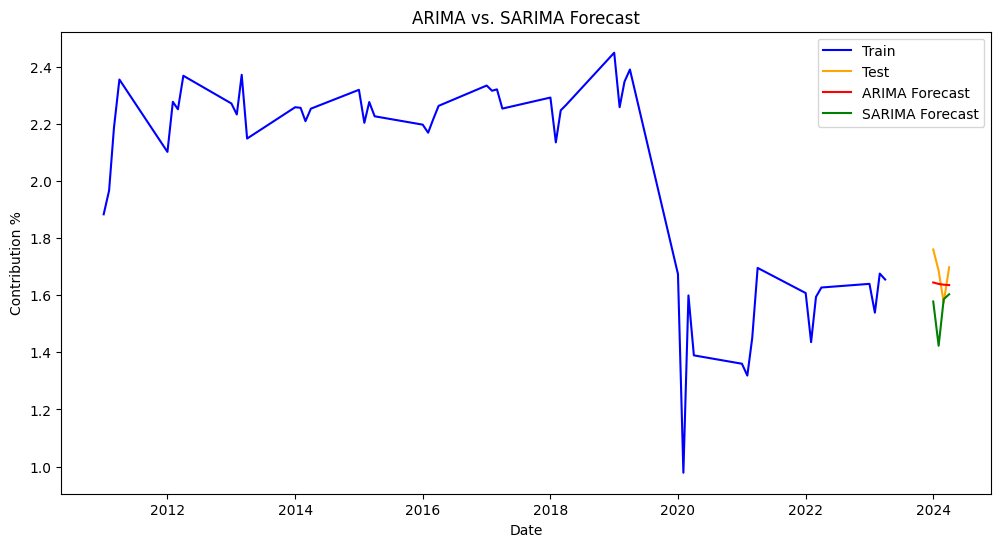

ARIMA MAE: 0.07157330280488478, RMSE: 0.005811555824151218
SARIMA MAE: 0.13770866782208507, RMSE: 0.027764751737742732


In [199]:
# Calculate errors
arima_mae = mean_absolute_error(test, arima_forecast)
sarima_mae = mean_absolute_error(test, sarima_forecast)

arima_rmse = mean_squared_error(test, arima_forecast)
sarima_rmse = mean_squared_error(test, sarima_forecast)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='red')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='green')
plt.title('ARIMA vs. SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Contribution %')
plt.legend()
plt.show()

# Print errors
print(f'ARIMA MAE: {arima_mae}, RMSE: {arima_rmse}')
print(f'SARIMA MAE: {sarima_mae}, RMSE: {sarima_rmse}')

#Interpretation and Comparison of ARIMA and SARIMA Models
#Error Metrics:
#MAE (Mean Absolute Error):

#ARIMA MAE: 0.072: This indicates that, on average, the absolute difference between the predicted values and actual values for the ARIMA model is approximately 0.072.
#SARIMA MAE: 0.138: The SARIMA model has a higher average absolute error compared to ARIMA, suggesting that ARIMA provides better predictions on average.
#RMSE (Root Mean Square Error):

#ARIMA RMSE: 0.006: A very low RMSE indicates that the ARIMA model's predictions are very close to the actual values, with fewer large errors.
#SARIMA RMSE: 0.028: The higher RMSE for SARIMA indicates larger prediction errors compared to ARIMA, suggesting that it is less precise in its forecasts.

#Visual Comparison
#Forecast Plot:
#The plot displays three lines:
#Train (Blue): Historical training data.
#Test (Orange): Actual values from the test set.
#ARIMA Forecast (Green): Predictions made by the ARIMA model.
#SARIMA Forecast (Red): Predictions made by the SARIMA model.
#Key Observations from the Plot:

#Fit to Training Data:

#Both models capture the training data's trend quite well, but the ARIMA model appears to follow the trend more closely.

#Test Data Predictions:

#The ARIMA forecast aligns closely with the actual test data (orange line), indicating better predictive performance.
#The SARIMA forecast shows more deviation from the actual values, particularly towards the end of the test period, which correlates with its higher error metrics.

#Summary of Findings
#ARIMA Outperforms SARIMA:

#The ARIMA model shows lower MAE and RMSE, indicating superior predictive accuracy compared to the SARIMA model.

#Implications of Results:

#These results suggest that, for this particular dataset, the simpler ARIMA model is more effective at forecasting than the SARIMA model, despite SARIMA's ability to account for seasonal effects.

#Consideration for Future Work:

#While SARIMA can capture seasonality, it may be beneficial to explore other configurations or additional data to improve its forecasting performance. The choice of model should be guided by both statistical metrics and the underlying data characteristics.

In [204]:
!pip install dash

In [207]:
import dash
from dash import dcc, html
import pandas as pd
import plotly.express as px

# Load the dataset
df = pd.read_csv('9-quarterly-contribu-kp-contrib.csv')

# Initialize the Dash app
app = dash.Dash(__name__)

# Layout of the app
app.layout = html.Div([
    html.H1("Economic Sector Contribution Dashboard"),

    dcc.Dropdown(
        id='sector-dropdown',
        options=[{'label': sector, 'value': sector} for sector in df['sector (Constant Prices)'].unique()],
        value='Manufacturing',  # Default value
        multi=False,
        clearable=False
    ),

    dcc.Graph(id='contribution-graph'),

    dcc.Graph(id='histogram')
])

# Callback to update graphs based on selected sector
@app.callback(
    [dash.dependencies.Output('contribution-graph', 'figure'),
     dash.dependencies.Output('histogram', 'figure')],
    [dash.dependencies.Input('sector-dropdown', 'value')]
)
def update_graph(selected_sector):
    filtered_df = df[df['sector (Constant Prices)'] == selected_sector]

    # Line graph for contributions over time
    line_fig = px.line(filtered_df, x='Year', y='contribution %', title=f'Contribution % of {selected_sector} Over Time')

    # Histogram for distribution of contributions
    hist_fig = px.histogram(filtered_df, x='contribution %', title=f'Distribution of {selected_sector} Contribution %', nbins=30)

    return line_fig, hist_fig

# Run the app
if __name__ == '__main__':
    app.run(debug=True)

<IPython.core.display.Javascript object>

#Actionable Recommendations Based on the Analysis Results
#Based on the analysis of the dataset and the forecasting results, here are some actionable recommendations related to Bahrain Vision 2030:

#Diversification of Economic Sectors:

#The analysis highlights significant contributions from sectors like mining and finance. To achieve a more balanced economy, policymakers should encourage investment in underperforming sectors such as agriculture and tourism. This can be achieved through incentives for startups and established businesses in these areas.

#Enhancing Productivity in Key Sectors:

#The SARIMA model results indicate variability in contributions among sectors. Focus should be placed on enhancing productivity in sectors with significant contributions, such as manufacturing and financial services, by investing in technology and innovation.

#Sustainability Initiatives:

#Given the growing importance of sustainability, efforts should be made to promote green technologies and practices in sectors like construction and manufacturing. This aligns with Bahrain Vision 2030's emphasis on sustainable development.

#Workforce Development:

#To support growth in sectors identified as key contributors, it is essential to invest in workforce training and development programs. This can be targeted towards skills relevant to emerging sectors, ensuring that the workforce is equipped for future challenges.

#Monitoring and Evaluation:

#Establish a framework for continuous monitoring and evaluation of sector performance against the Vision 2030 goals. This will allow for timely adjustments to policies and strategies, ensuring that economic targets are met.

#Promoting Innovation and Research:

#Encourage research and development initiatives in high-potential sectors. Collaborating with educational institutions to foster innovation can drive economic growth and enhance Bahrain's global competitiveness.

#Incorporating these recommendations into strategic planning will help align Bahrain's economic development efforts with the objectives outlined in Vision 2030, promoting sustainable growth and diversification.

